<a href="https://colab.research.google.com/github/NongNNew/Project_499/blob/main/Project_499_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

In [1]:
# Upload audio files from github
!git clone https://github.com/NongNNew/Project_499.git

fatal: destination path 'Project_499' already exists and is not an empty directory.


In [2]:
fruit_veget = ['กระชาย','กระท้อน','กระเทียม1','กระเทียม2','กระเพรา','กล้วยน้ำว้า','กล้วยหอม',
               'ข้าวโพด','ไข่น้ำ',
               'ตะขบไทย','ตะไคร้',
               'ถั่วฝักยาว','ถั่วลันเตา','ถั่วลิสง',
               'ทับทิม',
               'น้อยหน่า','น้ำเต้า',
               'ผักกระเฉด','ผักกุยช่าย','ผักขึ้นช่าย','ผักชะอม','ผักชี','ผักชีฝรั่ง','ผักตำลึง',
               'มะปราง','มะพลับ','มะละกอ','มะกรูด','มะเขือพวง','มะเขือเทศ','มะระ','มะรุม','มะตูม','มันแกว1','มันแกว2','มันเทศ','มันฝรั่ง','มันสำปะหลัง',
               'บวบ','ใบชะพลู1','ใบชะพลู2','ใบบัวบก','ใบแมงลัก','ใบยอ',
               'พริกขี้หนู','พริกสด','พุทรา','เพกา',
               'ฝรั่ง',
               'ฟัก','ฟักทอง',
               'สับปะรด','สะเดา','สะระแหน่',
               'หัวหอม1','หัวหอม2']

source = {'audio_time':[],
          'sampling_rate':[],
          'feature_extraction':[],
          'label':[],
          'description':[]}

In [3]:
!pip install python_speech_features
import python_speech_features
from scipy.signal.windows import hamming

def feature_mfcc(y,sr):
    return (python_speech_features.mfcc(signal=y, 
                                    samplerate=sr, 
                                    winlen= 512/sr, 
                                    winstep= 160/sr,
                                    numcep= 13,
                                    nfilt= 40, 
                                    nfft= 512,
                                    lowfreq= 0,
                                    highfreq= None,
                                    preemph= 0.97, 
                                    ceplifter= 0,
                                    winfunc= hamming))

In [4]:
import pandas as pd
from glob import glob
import librosa

for types in fruit_veget:
    audio_files = glob('/content/Project_499/Record_audio/' + str(types) + '/*.wav')

    for audio in audio_files:
        y,sr = librosa.load(audio,duration=5,offset=0)
        source['description'].append(str(types))
        source['audio_time'].append(y)
        source['sampling_rate'].append(sr)
        source['feature_extraction'].append(feature_mfcc(y,sr))
        source['label'].append(fruit_veget.index(types))

In [5]:
df = pd.DataFrame.from_dict(source)
df

,audio_time,sampling_rate,feature_extraction,label,description
0,"[0.0004119873, 0.00061035156, 0.0005340576, 0....",22050,"[[-14.031458292064183, -9.719918182168303, 3.0...",0,กระชาย
1,"[1.5258789e-05, -3.0517578e-05, 4.5776367e-05,...",22050,"[[-13.895163210723114, -10.534242113550562, 0....",0,กระชาย
2,"[-0.00010681152, -0.00010681152, -0.0001525878...",22050,"[[-14.047682378884087, -10.559749338871004, 1....",0,กระชาย
3,"[-0.00012207031, -0.00018310547, -6.1035156e-0...",22050,"[[-13.937838344743476, -10.52677763983171, 0.7...",0,กระชาย
4,"[-1.5258789e-05, 1.5258789e-05, -1.5258789e-05...",22050,"[[-13.834222688815137, -11.278032760622157, -1...",0,กระชาย
...,...,...,...,...,...
1115,"[-0.00021362305, -0.00019836426, -0.0001678466...",22050,"[[-13.600642153773194, -15.096089567076714, -0...",55,หัวหอม2
1116,"[-7.6293945e-05, -9.1552734e-05, 0.0, 1.525878...",22050,"[[-13.93405270581039, -11.744337964457122, 1.2...",55,หัวหอม2
1117,"[-7.6293945e-05, -3.0517578e-05, 4.5776367e-05...",22050,"[[-14.064456461828245, -10.130237156697339, 2....",55,หัวหอม2
1118,"[1.5258789e-05, -4.5776367e-05, 4.5776367e-05,...",22050,"[[-13.862199697176345, -10.033334893928362, 0....",55,หัวหอม2


In [6]:
import numpy as np
import pandas as pd

Test = pd.DataFrame(columns=source.keys())

# Create test data
for description in np.unique(df['description']):
    imp = df[df['description']==description].sample(5,random_state=1)
    Test = pd.concat([Test,imp], axis=0)

# Create train and validation data
Train = df.drop(Test.index)

X_train, X_test = np.array(Train['feature_extraction'].to_list()), np.array(Test['feature_extraction'].to_list())
y_train, y_test = np.array(Train['label'].to_list()), np.array(Test['label'].to_list())

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [7]:
import tensorflow as tf
from tensorflow import keras 
np.random.seed(1)
tf.random.set_seed(1)

# Convolutional Neural Networks
model = keras.Sequential()
model.add(keras.layers.Conv2D(128, 5, input_shape=(X_train.shape[1], X_train.shape[2], 1), activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64, 5, activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(128, 5, activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(len(np.unique(df['label'])), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 683, 9, 128)       3328      
_________________________________________________________________
dropout (Dropout)            (None, 683, 9, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 341, 4, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 341, 4, 64)        204864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 341, 4, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 170, 2, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 2, 128)       2

In [8]:
# Fitting model
history = model.fit(X_train[:,:,:,None], y_train, epochs=100, validation_data=(X_valid[:,:,:,None],y_valid),batch_size=80)

Epoch 1/100
8/8 [==============================] - 6s 267ms/step - loss: 4.1424 - accuracy: 0.0143 - val_loss: 4.0221 - val_accuracy: 0.0095
Epoch 2/100
8/8 [==============================] - 1s 86ms/step - loss: 4.0209 - accuracy: 0.0254 - val_loss: 4.0194 - val_accuracy: 0.0238
Epoch 3/100
8/8 [==============================] - 1s 86ms/step - loss: 4.0004 - accuracy: 0.0381 - val_loss: 3.9796 - val_accuracy: 0.0429
Epoch 4/100
8/8 [==============================] - 1s 87ms/step - loss: 3.8976 - accuracy: 0.0619 - val_loss: 3.8634 - val_accuracy: 0.0667
Epoch 5/100
8/8 [==============================] - 1s 86ms/step - loss: 3.7555 - accuracy: 0.0730 - val_loss: 3.7191 - val_accuracy: 0.1429
Epoch 6/100
8/8 [==============================] - 1s 86ms/step - loss: 3.5302 - accuracy: 0.1175 - val_loss: 3.5876 - val_accuracy: 0.1810
Epoch 7/100
8/8 [==============================] - 1s 86ms/step - loss: 3.2482 - accuracy: 0.1619 - val_loss: 3.2987 - val_accuracy: 0.2429
Epoch 8/100
8/8 [==

In [9]:
# Evaluate model
print(f'Train Accuracy: { model.evaluate(X_train[:,:,:,None],y_train)[1]}')
print(f'Test Accuracy: {model.evaluate(X_test[:,:,:,None],y_test)[1]}')

20/20 [==============================] - 1s 18ms/step - loss: 0.0115 - accuracy: 1.0000
Train Accuracy: 1.0
9/9 [==============================] - 0s 31ms/step - loss: 0.2975 - accuracy: 0.9321
Test Accuracy: 0.9321428537368774


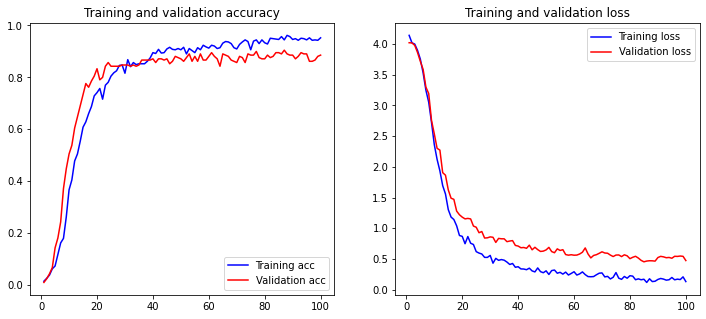

In [11]:
import matplotlib.pyplot as plt

# plot the accuracy and loss plots between training and validation data
# verlify overfitting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1,len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x,acc,'b',label='Training acc')
plt.plot(x,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(x,loss,'b',label='Training loss')
plt.plot(x,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [10]:
from sklearn.metrics import classification_report

# classification report
predicted_classes = np.argmax(np.round(model.predict(X_test[:,:,:,None])),axis=1)
correct = np.where(predicted_classes==y_test)[0]
target_names = [f"Class {label}" for label in range(len(np.unique(df['label'])))]

print(f"From {len(y_test)} labels're founding {len(correct)} correct labels.")
print('')
print(classification_report(y_test, predicted_classes, target_names=target_names))

From 280 labels're founding 252 correct labels.

              precision    recall  f1-score   support

     Class 0       0.18      1.00      0.30         5
     Class 1       1.00      0.80      0.89         5
     Class 2       1.00      1.00      1.00         5
     Class 3       1.00      0.20      0.33         5
     Class 4       1.00      0.80      0.89         5
     Class 5       1.00      1.00      1.00         5
     Class 6       1.00      1.00      1.00         5
     Class 7       1.00      1.00      1.00         5
     Class 8       1.00      0.80      0.89         5
     Class 9       1.00      0.80      0.89         5
    Class 10       1.00      1.00      1.00         5
    Class 11       1.00      1.00      1.00         5
    Class 12       1.00      1.00      1.00         5
    Class 13       1.00      0.80      0.89         5
    Class 14       1.00      1.00      1.00         5
    Class 15       0.83      1.00      0.91         5
    Class 16       1.00      1.0